In [29]:
import numpy as np
import statsmodels.api as sm
from scipy import stats
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
import seaborn as sns 
import time
%matplotlib inline

In [30]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, BaggingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.kernel_approximation import RBFSampler
import random
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from sklearn.model_selection import train_test_split
from keras.optimizers import Adam
from keras.wrappers.scikit_learn import KerasClassifier
import xgboost as xgb
import lightgbm as lgb
from xgboost import XGBClassifier

In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#modules for data cleaning and data analysis
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
import scipy.stats as stats

#modules for model building
from sklearn.model_selection import GridSearchCV


#baseline linear model
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

#modules for hyper parameter tuning
from sklearn.model_selection import GridSearchCV

#modules for model evaluation
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_score, accuracy_score, f1_score, r2_score
from sklearn.metrics import precision_recall_curve, roc_curve

In [32]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
import pandas as pd
import plotly.express as px

#loading the dataset
df_train = pd.read_csv('/kaggle/input/fraud-detection/fraudTrain.csv')
df_test = pd.read_csv('/kaggle/input/fraud-detection/fraudTest.csv')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [33]:
#concatenating the two datasets
df = pd.concat([df_train, df_test]).reset_index()

df.drop(df.columns[:2], axis=1, inplace=True)


In [34]:
#converting trans_date_trans_time into datetime
df['trans_date_trans_time'] = pd.to_datetime(df['trans_date_trans_time'])


# deriving additonal columns from 'trans_date_trans_time'
#deriving 'year_month'
df['transiction_year_month'] = df['trans_date_trans_time'].dt.to_period('M')
#deriving 'day of the week'
df['transiction_day_of_week'] = df['trans_date_trans_time'].dt.day_name()
#deriving hour
df['transiction_hour'] = df['trans_date_trans_time'].dt.hour

In [35]:
#finding age
#converting 'dob' column to datetime
df['dob'] = pd.to_datetime(df['dob'])
df['age'] = np.round((df['trans_date_trans_time'] - df['dob'])/np.timedelta64(1, 'Y'))

#dropping variables
df.drop(['cc_num', 'street','trans_date_trans_time','first', 'last', 'dob'] , axis=1, inplace=True)

In [36]:
df_org = df.copy()

<AxesSubplot:title={'center':'Quantidade de fraudes por categoria'}, xlabel='category', ylabel='is_fraud'>

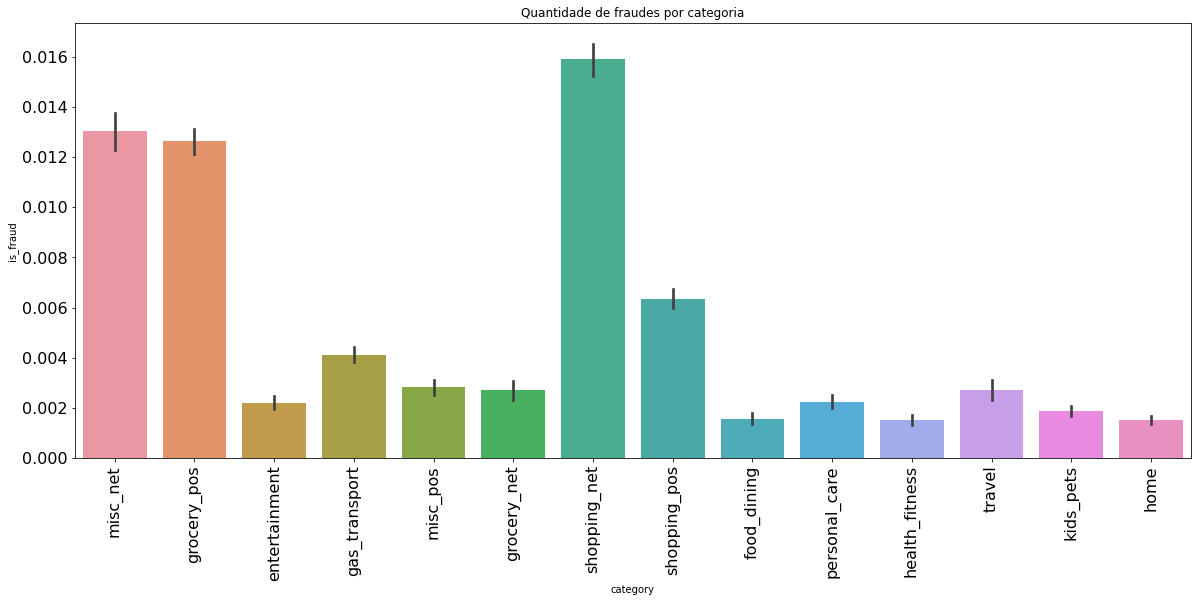

In [37]:
# Category
plt.figure(figsize=(20,8))
plt.title('Quantidade de fraudes por categoria')
plt.xticks(rotation='vertical', fontsize=16)
plt.yticks(fontsize=16)
sns.barplot(x="category", y='is_fraud' ,data=df)

<AxesSubplot:title={'center':'Número de transações fraudulentas por sexo'}, xlabel='gender', ylabel='is_fraud'>

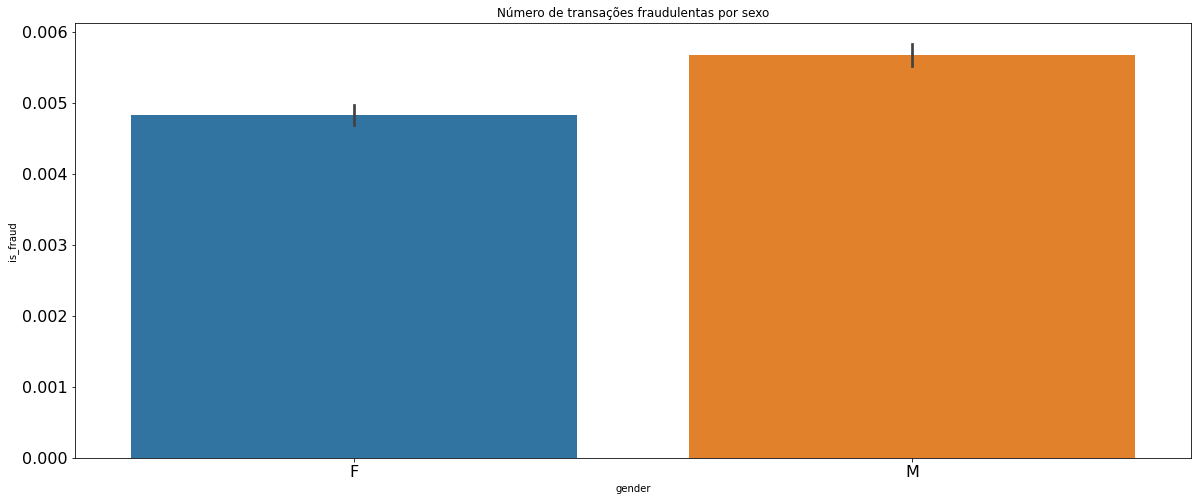

In [38]:
# Gender
plt.figure(figsize=(20,8))
plt.title('Número de transações fraudulentas por sexo')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
sns.barplot(x="gender", y='is_fraud' ,data=df)

In [39]:
df['age'] = df['age'].astype(float)
df['age'] = pd.cut(df['age'], bins=[0, 20, 40, 60, 80, np.inf], labels=['<= 20', '20-40', '40-60', '60-80', '> 80'])

In [40]:
#constructing the age-transaction count distribution
df_age = df[['age','trans_num']].groupby(['age']).count().reset_index()
df_age.columns = ['age', 'age_count']

#creating the age-fraud distribution
df_fraud_age = df[['age', 'trans_num', 'is_fraud']].groupby(['age','is_fraud']).count().reset_index()
df_fraud_age.columns = ['age', 'is_fraud', 'Transaction count']

df_fraud_age = df_fraud_age.merge(df_age[['age', 'age_count']], how='inner', on='age')

df_fraud_age['Porcentagem'] = (df_fraud_age['Transaction count']/df_fraud_age['age_count'])*100

df_fraud_age.drop(['Transaction count', 'age_count'] , axis=1, inplace=True)
df_fraud_age

,age,is_fraud,Porcentagem
0,<= 20,0,99.462464
1,<= 20,1,0.537536
2,20-40,0,99.546849
3,20-40,1,0.453151
4,40-60,0,99.485298
5,40-60,1,0.514702
6,60-80,0,99.349708
7,60-80,1,0.650292
8,> 80,0,99.320155
9,> 80,1,0.679845


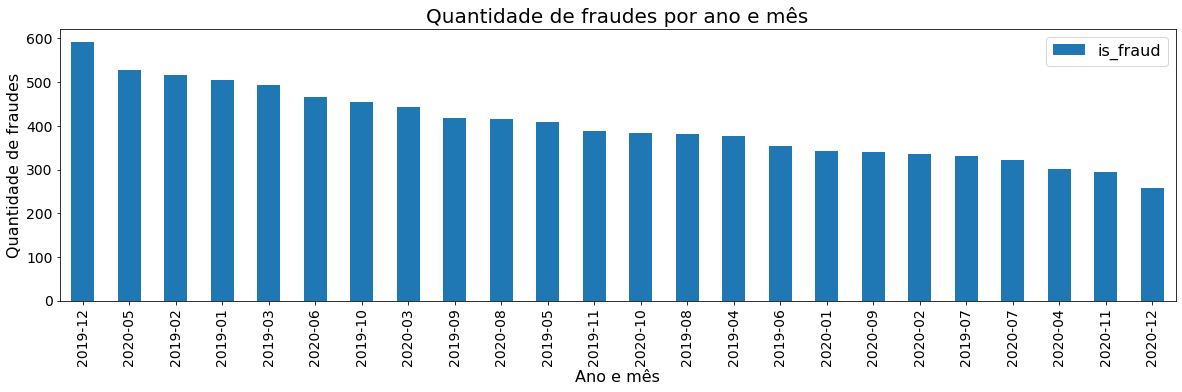

In [41]:

df.groupby('transiction_year_month')['is_fraud'].sum().sort_values(ascending=False).plot(kind='bar', figsize=(20,5))
plt.title('Quantidade de fraudes por ano e mês', fontsize=20)
plt.xlabel('Ano e mês', fontsize=16)
plt.ylabel('Quantidade de fraudes', fontsize=16)
plt.xticks(rotation='vertical', fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=16)
plt.show()

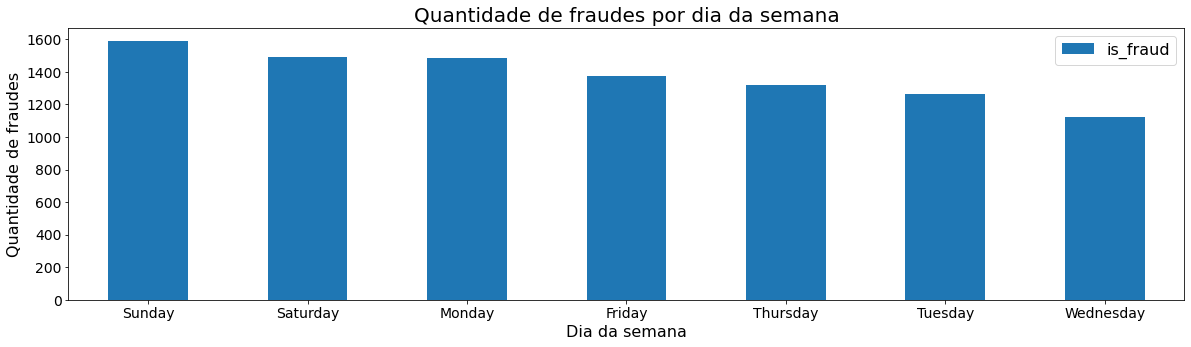

In [42]:
df.groupby('transiction_day_of_week')['is_fraud'].sum().sort_values(ascending=False).plot(kind='bar', figsize=(20,5))
plt.title('Quantidade de fraudes por dia da semana', fontsize=20)
plt.xlabel('Dia da semana', fontsize=16)
plt.ylabel('Quantidade de fraudes', fontsize=16)
plt.xticks(rotation='horizontal', fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=16)
plt.show()

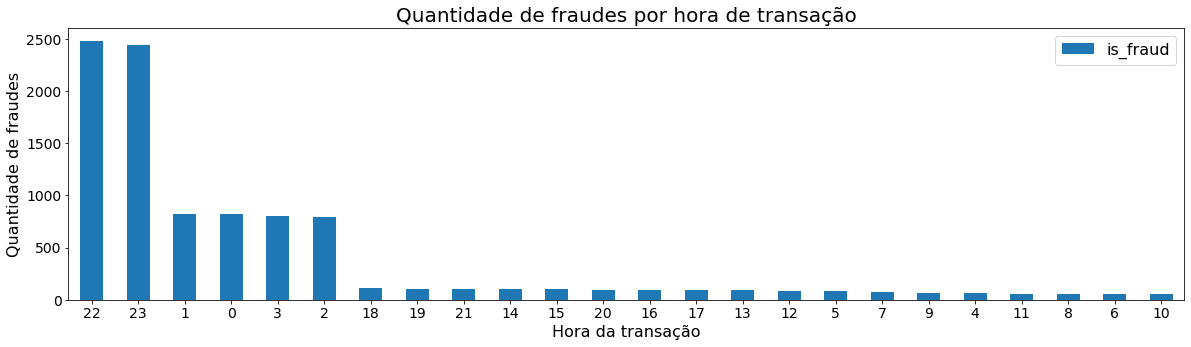

In [43]:
df.groupby('transiction_hour')['is_fraud'].sum().sort_values(ascending=False).plot(kind='bar', figsize=(20,5))
plt.title('Quantidade de fraudes por hora de transação', fontsize=20)
plt.xlabel('Hora da transação', fontsize=16)
plt.ylabel('Quantidade de fraudes', fontsize=16)
plt.xticks(rotation='horizontal', fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=16)
plt.show()

In [44]:
#removing unnecessary variables
df.drop(['trans_num','merchant','city','state','job',
         'zip', 'lat', 'long', 'city_pop', 'unix_time', 
         'merch_lat','merch_long', 'transiction_year_month'],
        axis=1, inplace=True)


In [45]:
df.head()

,category,amt,gender,is_fraud,transiction_day_of_week,transiction_hour,age
0,misc_net,4.97,F,0,Tuesday,0,20-40
1,grocery_pos,107.23,F,0,Tuesday,0,40-60
2,entertainment,220.11,M,0,Tuesday,0,40-60
3,gas_transport,45.00,M,0,Tuesday,0,40-60
4,misc_pos,41.96,M,0,Tuesday,0,20-40


In [46]:
#one-hot encoding
category_onehot = pd.get_dummies(df.category, prefix='category', drop_first=True)
gender_onehot = pd.get_dummies(df.gender, prefix='gender', drop_first=True)
day_of_week_onehot = pd.get_dummies(df.transiction_day_of_week, prefix='day', drop_first=True)
age_onehot = pd.get_dummies(df.age, prefix='age', drop_first=True)

df = pd.concat([df, category_onehot,gender_onehot,day_of_week_onehot,age_onehot], axis=1)

In [47]:
df.drop(['category','gender','transiction_day_of_week', 'age'],axis=1, inplace=True)

In [48]:
#storing the number of values in each class
non_fraud_count, fraud_count = df.is_fraud.value_counts()

In [49]:
fraud_count

9651

In [50]:
non_fraud_count

1842743

In [51]:
#innput-output split
X = df.drop("is_fraud", axis=1)
y = df["is_fraud"]

In [52]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split


# Split the data into two classes
class_0 = df[df["is_fraud"] == 0]
class_1 = df[df["is_fraud"] == 1]

# Determine the number of samples in the minority class
minority_class_size = min(class_0.shape[0], class_1.shape[0])

# Interpolate the data in the minority class to have the same number of samples as the majority class
interpolated_class_1 = class_1.sort_values("is_fraud", ascending=False).interpolate(method="linear")
interpolated_class_0 = class_0.sort_values("is_fraud").interpolate(method="linear")

# Sample the interpolated data to get the desired number of samples
interpolated_class_1 = interpolated_class_1.sample(n=minority_class_size, replace=False, random_state=42)
interpolated_class_0 = interpolated_class_0.sample(n=minority_class_size, replace=False, random_state=42)

# Concatenate the interpolated data back into one DataFrame
interpolated_df = pd.concat([interpolated_class_0, interpolated_class_1], axis=0)

# Split the interpolated data into features (X) and target (y)
X_interpolated = interpolated_df.drop("is_fraud", axis=1).values
y_interpolated = interpolated_df["is_fraud"].values

# Split the interpolated data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_interpolated, y_interpolated, test_size=0.3, random_state=42)

In [53]:
X_interpolated.shape

(19302, 26)

In [54]:
y_interpolated.shape

(19302,)

In [55]:
def create_lstm_model(neurons=1, activation='relu'):
    model = Sequential()
    model.add(LSTM(neurons, activation=activation, input_shape=(1, X_train.shape[1])))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [56]:
xgb = XGBClassifier()
lgbm = lgb.LGBMClassifier()
svm = SGDClassifier()
rf = RandomForestClassifier()
dt = DecisionTreeClassifier()
lstm = KerasClassifier(build_fn=create_lstm_model, epochs=10, batch_size=32, verbose=0)

# Define second layer model
ensemble = RandomForestClassifier()

<ipython-input-56-5314d3a8cd9c>:6: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  lstm = KerasClassifier(build_fn=create_lstm_model, epochs=10, batch_size=32, verbose=0)


In [57]:
# Define hyperparameters for each model

# Define hyperparameter grid for XGBClassifier
xgb_grid = {'max_depth': [3, 4, 5],
            'learning_rate': [0.1, 0.01, 0.05],
            'n_estimators': [100, 200, 300]}

# Define hyperparameter grid for LGBMClassifier
lgbm_grid = {'max_depth': [3, 4, 5],
             'learning_rate': [0.1, 0.01, 0.05],
             'n_estimators': [100, 200, 300]}

# Define hyperparameter grid for SGDClassifier
svm_grid = {'loss': ['hinge', 'log', 'modified_huber'],
            'penalty': ['l1', 'l2', 'elasticnet'],
            'alpha': [0.001, 0.01, 0.1]}

# Define hyperparameter grid for RandomForestClassifier
rf_grid = {'max_depth': [3, 4, 5],
           'n_estimators': [100, 200, 300]}

# Define hyperparameter grid for DecisionTreeClassifier
dt_grid = {'max_depth': [3, 4, 5]}


# Define hyperparameter grid for LSTM
lstm_grid = {'neurons': [8, 16, 32, 64], 'activation': ['relu', 'tanh']}

# Define hyperparameter grid for Random Forest
ensemble_grid = {'n_estimators': [100, 200, 300],
                 'max_depth': [3, 4, 5]}

In [58]:
# Define the models and their corresponding hyperparameters in a list
models = [('xgb', xgb, xgb_grid),          
          ('lgbm', lgbm, lgbm_grid),          
          ('svm', svm, svm_grid),
          ('rf', rf, rf_grid),          
          ('dt', dt, dt_grid),
          ('lstm', lstm, lstm_grid)]

accuracies = []
precisions = []
recalls = []
f1_scores = []

In [59]:
X_train_lstm = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test_lstm = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

In [60]:
trained_models = []
# Train the first layer models on the training data with hyperparameter tuning
final_time = 0

for name, model, grid in models:
    search = GridSearchCV(estimator=model, param_grid=grid, cv=5)
    if model is lstm:
      search.fit(X_train_lstm, y_train)
      model = search.best_estimator_
      start_time = time.time()
      model.fit(X_train_lstm, y_train)
      final_time += time.time() - start_time
      trained_models.append(model)
      accuracies.append(accuracy_score(y_test, model.predict(X_test_lstm)))
      precisions.append(precision_score(y_test, model.predict(X_test_lstm)))
      recalls.append(recall_score(y_test, model.predict(X_test_lstm)))
      f1_scores.append(f1_score(y_test, model.predict(X_test_lstm)))
    else:
      search.fit(X_train, y_train)
      model = search.best_estimator_
      start_time = time.time()
      model.fit(X_train, y_train)
      final_time += time.time() - start_time
      trained_models.append(model)
      accuracies.append(accuracy_score(y_test, model.predict(X_test)))
      precisions.append(precision_score(y_test, model.predict(X_test)))
      recalls.append(recall_score(y_test, model.predict(X_test)))
      f1_scores.append(f1_score(y_test, model.predict(X_test)))

/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_stochastic_gradient.py:163: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_stochastic_gradient.py:163: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_stochastic_gradient.py:163: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_stochastic_gradient.py:163: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/l

181/181 [==============================] - 0s 2ms/step


In [61]:
# Use the trained first layer models to predict on the training data
predictions = []
for model in trained_models:
    if model is trained_models[-1]:
      prediction = model.predict(X_train_lstm)
    else:
      prediction = model.predict(X_train)
    predictions.append(prediction)
second_layer_input = np.column_stack(predictions)

# Define hyperparameter grid for Random Forest
ensemble_grid = {'n_estimators': [100, 200, 300],
                 'max_depth': [3, 4, 5]}

# Apply GridSearchCV to ensemble classifier
ensemble_search = GridSearchCV(estimator=ensemble, param_grid=ensemble_grid, cv=5)
ensemble_search.fit(second_layer_input, y_train)
ensemble_model = ensemble_search.best_estimator_

# Train the ensemble model on the outputs of the first layer models with hyperparameter tuning
start_time = time.time()
ensemble_model.fit(second_layer_input, y_train)
final_time += time.time() - start_time

# Make predictions using the second layer model
predictions = []
for model in trained_models:
    if model is trained_models[-1]:
      prediction = model.predict(X_test_lstm)
    else:
      prediction = model.predict(X_test)
    predictions.append(prediction)
second_layer_test = np.column_stack(predictions)

ensemble_preds = ensemble_model.predict(second_layer_test)

181/181 [==============================] - 0s 2ms/step


In [62]:
acc_ensemble = accuracy_score(y_test, ensemble_preds)
prec_ensemble = precision_score(y_test, ensemble_preds)
rec_ensemble = recall_score(y_test, ensemble_preds)
f1_ensemble = f1_score(y_test, ensemble_preds)

In [63]:
# print results
print("Extreme Gradient Boosting:")
print("Accuracy:", accuracies[0].round(4))
print("Precision:", precisions[0].round(4))
print("Recall:", recalls[0].round(4))
print("F1 Score:", f1_scores[0].round(4))

print("\nLightGBM:")
print("Accuracy:", accuracies[1].round(4))
print("Precision:", precisions[1].round(4))
print("Recall:", recalls[1].round(4))
print("F1 Score:", f1_scores[1].round(4))

print("\nSVM:")
print("Accuracy:", accuracies[2].round(4))
print("Precision:", precisions[2].round(4))
print("Recall:", recalls[2].round(4))
print("F1 Score:", f1_scores[2].round(4))

print("\nRandom Forest:")
print("Accuracy:", accuracies[3].round(4))
print("Precision:", precisions[3].round(4))
print("Recall:", recalls[3].round(4))
print("F1 Score:", f1_scores[3].round(4))

print("\nDecision Tree:")
print("Accuracy:", accuracies[4].round(4))
print("Precision:", precisions[4].round(4))
print("Recall:", recalls[4].round(4))
print("F1 Score:", f1_scores[4].round(4))

print("\nLSTM:")
print("Accuracy:", accuracies[5].round(4))
print("Precision:", precisions[5].round(4))
print("Recall:", recalls[5].round(4))
print("F1 Score:", f1_scores[5].round(4))

print("\nEnsemble:")
print("Accuracy:", acc_ensemble.round(4))
print("Precision:", prec_ensemble.round(4))
print("Recall:", rec_ensemble.round(4))
print("F1 Score:", f1_ensemble.round(4))

print(f"\nTraining total time: {final_time:.2f} seconds")

Extreme Gradient Boosting:
Accuracy: 0.9744
Precision: 0.9748
Recall: 0.9741
F1 Score: 0.9744

LightGBM:
Accuracy: 0.9729
Precision: 0.9724
Recall: 0.9734
F1 Score: 0.9729

SVM:
Accuracy: 0.8154
Precision: 0.9263
Recall: 0.6854
F1 Score: 0.7879

Random Forest:
Accuracy: 0.8971
Precision: 0.96
Recall: 0.8287
F1 Score: 0.8895

Decision Tree:
Accuracy: 0.9496
Precision: 0.9717
Recall: 0.9261
F1 Score: 0.9484

LSTM:
Accuracy: 0.9541
Precision: 0.944
Recall: 0.9655
F1 Score: 0.9546

Ensemble:
Accuracy: 0.9744
Precision: 0.9748
Recall: 0.9741
F1 Score: 0.9744

Training total time: 20.93 seconds
